In [1]:
import torch, torchvision

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import method
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from tqdm import tqdm

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

In [6]:
import os
from PIL import Image

valdir = './imnet/'
filenames = os.listdir(valdir)
batch_size = 300
img_batch = []
for fn in filenames[:batch_size]:
    img = Image.open(valdir + fn)
    img = transform(img)
    img = normalize(img)
    img_batch.append(img.numpy())

img_batch = np.array(img_batch)

In [10]:
def iterate_minibatches(inputs, adv, batchsize=100):
    #make transform
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        excerpt = slice(start_idx, start_idx + batchsize)
        cur_batch_pert = []
        for path in inputs[excerpt]:
            cur_img = Image.open('./imnet/'+path)
            if np.array(cur_img).ndim != 3 or np.array(cur_img).shape[-1] != 3:
                continue
            cur_img = normalize(transform(cur_img))
            
            cur_img_pert = torch.FloatTensor(np.copy(cur_img.numpy() + adv))
            cur_img_pert = normalize(cur_img_pert)
            cur_batch_pert.append(cur_img_pert)
        yield cur_batch_pert

In [11]:
d = torch.device('cuda')
vgg19 = torchvision.models.vgg19(pretrained=True)
vgg19.to(d);
vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [12]:
model = method.VGGWrapper(vgg19, d)

In [13]:
adv = np.load('perts3/vgg19_block2_pool.npy')
adv = adv/0.04
np.max(adv)

1.0

In [43]:
def make_probs(adv, img_path):
    #corrupt_img = np.clip(img+adv, 0, 1)
    cur_img = Image.open('./imnet/'+img_path)
    cur_img = transform(cur_img)
    cur_img_pert = torch.FloatTensor(np.copy(cur_img.numpy() + adv))
    cur_img_pert = normalize(cur_img_pert).view((1, 3, 224, 224)).to(d)
    
    f = torch.nn.Softmax(dim=1)
    logits = vgg19(cur_img_pert)
    
    probs = method.tonp(f(logits))
    probs.sort()
    top_probs = probs[0, -5:][::-1]
    return top_probs

In [78]:
#! mkdir exp_figs

In [44]:
images = os.listdir('./imnet')
probs = []
n = 100
R = np.linspace(0, 50/255, 100)
for i in tqdm(range(n)):
    adv1 = adv*R[i]
    probs.append(make_probs(adv1.copy(), images[100]))

100%|██████████| 100/100 [00:01<00:00, 70.77it/s]


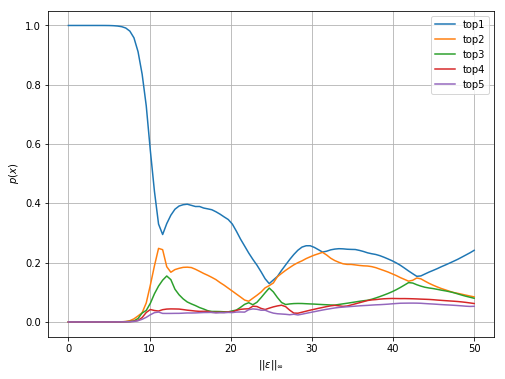

In [51]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(R*255, np.array(probs)[:, i], label="top"+str(i+1))
plt.legend()
plt.grid()
plt.xlabel("$||\epsilon||_{\infty}$")
plt.ylabel("$p(x)$")
plt.savefig("exp_figs/probs.png")

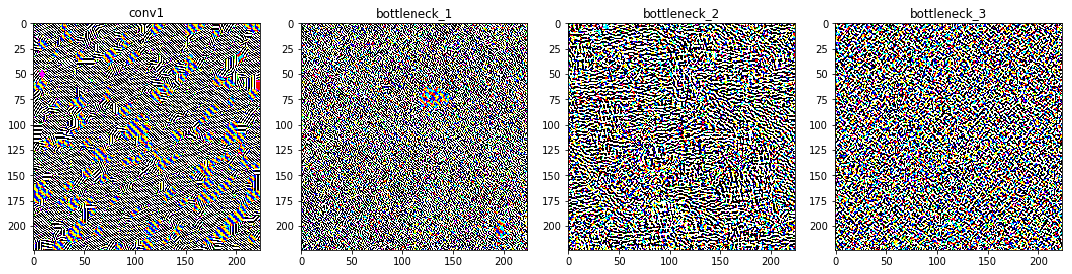

In [10]:
plt.figure(figsize=(15, 4))
layers = {
    "conv1" : 1,
    "bottleneck_1" : 5,
    "bottleneck_2" : 6,
    "bottleneck_3" : 7}
for i, layer in enumerate(layers):
    perm = np.load('perts3/resnet50_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.tight_layout()
plt.savefig("exp_figs/resnet50_2.png")

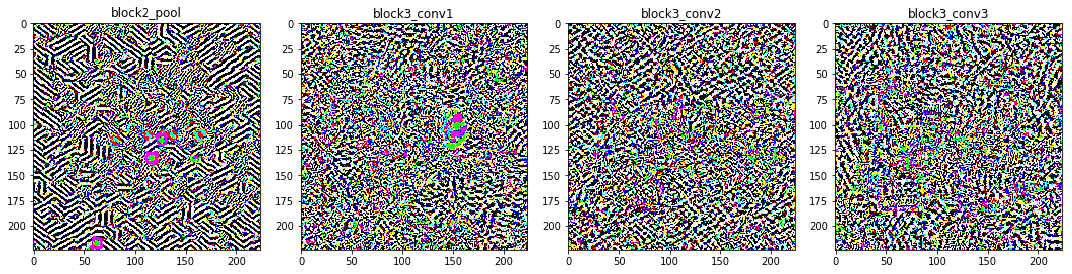

In [11]:
plt.figure(figsize=(15, 4))
layers = {"block2_pool" : 10,
        "block3_conv1" : 12,
        "block3_conv2" :  14,
        "block3_conv3" : 16}
for i, layer in enumerate(layers):
    perm = np.load('perts3/vgg16_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.tight_layout()
plt.savefig("exp_figs/vgg16_2.png")

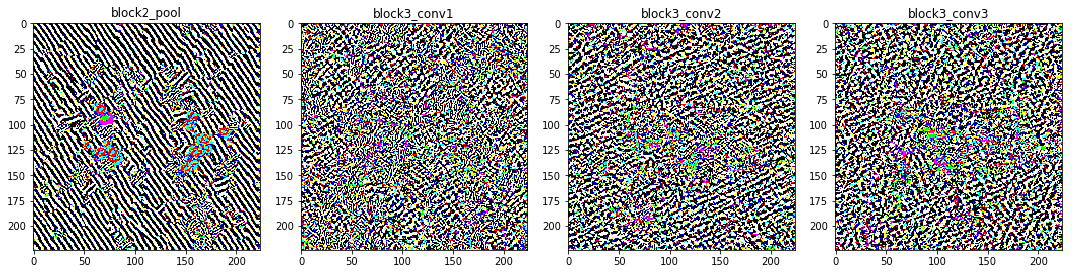

In [12]:
plt.figure(figsize=(15, 4))
layers = {"block2_pool" : 10,
        "block3_conv1" : 12,
        "block3_conv2" :  14,
        "block3_conv3" : 16}
for i, layer in enumerate(layers):
    perm = np.load('perts3/vgg19_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.tight_layout()
plt.savefig("exp_figs/vgg19_2.png")

## Example

In [10]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def transform(img):
    img -= mean[:, None, None]
    img /= std[:, None, None]
    return img

In [15]:
from skimage.io import imread
from skimage.transform import resize
import os

img_batch = []
images = os.listdir('./imnet')

for path in tqdm(images[:64]):
    try:
        img = imread('./imnet/'+path).transpose((2, 0, 1))
        img = resize(img, (3, 224, 224)).astype(float)
        img_batch.append(img.copy())
    except:
        pass

img_batch = np.array(img_batch)

100%|██████████| 64/64 [00:01<00:00, 45.83it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


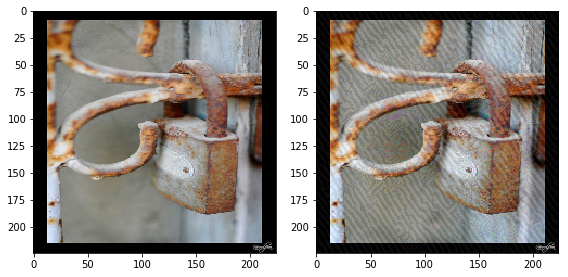

In [29]:
perm = np.load('perts3/vgg19_block2_pool.npy')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_batch[0].transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow((img_batch[0] + perm).transpose((1, 2, 0)))
plt.tight_layout()
plt.savefig("exp_figs/example.png")